### Read from DB ###

In [65]:
import sqlalchemy as sql
import pandas as pd
import warnings
import numpy as np
warnings.filterwarnings("ignore")

In [2]:
engine=sql.create_engine('sqlite:///crypto_price_db.db')

In [5]:
engine.table_names()

['cypto_price']

In [9]:
df=pd.read_sql_table('cypto_price', con=engine, index_col='Date', parse_dates=True)
df=df.drop(columns='index')
df.head()

,Close,Volume,Ticker
Date,,,
2014-09-17,457.334015,21056800,BTC
2014-09-18,424.440002,34483200,BTC
2014-09-19,394.795990,37919700,BTC
2014-09-20,408.903992,36863600,BTC
2014-09-21,398.821014,26580100,BTC


In [10]:
df.index

DatetimeIndex(['2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22', '2014-09-23', '2014-09-24',
               '2014-09-25', '2014-09-26',
               ...
               '2022-07-25', '2022-07-26', '2022-07-27', '2022-07-28',
               '2022-07-29', '2022-07-30', '2022-07-31', '2022-08-01',
               '2022-08-02', '2022-08-03'],
              dtype='datetime64[ns]', name='Date', length=2878, freq=None)

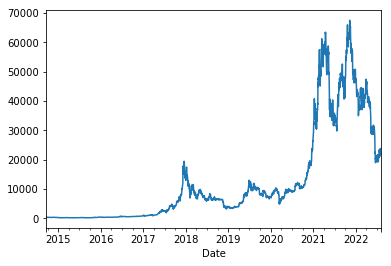

In [11]:
df['Close'].plot()

### ML ###

create a table like below: 
<img src='./images/sample_features.png' width=720>

In [41]:
features=df[['Close']]
window_size=5
for i in range(1, window_size+1): 
    features[f'Close T-{i}']=features['Close'].shift(i)

features=features.dropna()
features.head()

,Close,Close T-1,Close T-2,Close T-3,Close T-4,Close T-5
Date,,,,,,
2014-09-22,402.152008,398.821014,408.903992,394.795990,424.440002,457.334015
2014-09-23,435.790985,402.152008,398.821014,408.903992,394.795990,424.440002
2014-09-24,423.204987,435.790985,402.152008,398.821014,408.903992,394.795990
2014-09-25,411.574005,423.204987,435.790985,402.152008,398.821014,408.903992
2014-09-26,404.424988,411.574005,423.204987,435.790985,402.152008,398.821014


In [54]:
y=features[['Close']]
X=features.drop(columns=['Close'])

Split into training and testing

In [55]:
# split at 2021 / 6
X_train=X.loc[:'2021-06']
y_train=y.loc[:'2021-06']
X_test=X.loc['2021-07':]
y_test=y.loc['2021-07':]

In [56]:
display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(2474, 5)

(399, 5)

(2474, 1)

(399, 1)

### Scale Data ###

In [57]:
from sklearn.preprocessing import MinMaxScaler
X_scaler=MinMaxScaler()
X_scaler.fit(X_train)
X_train_scaled=X_scaler.transform(X_train)
X_test_scaled=X_scaler.transform(X_test)

In [58]:
y_scaler=MinMaxScaler()
y_scaler.fit(y_train)
y_train_scaled=y_scaler.transform(y_train)
y_test_scaled=y_scaler.transform(y_test)

### Reshape ###

In [59]:
X_train_scaled=X_train_scaled.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_scaled=X_test_scaled.reshape(X_test.shape[0], X_test.shape[1], 1)

### Build Model ###

In [88]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [92]:
model=Sequential()
model.add(LSTM(units=30, return_sequences=True, input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=30, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=30))
model.add(Dense(units=1, activation='linear'))

In [93]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 5, 30)             3840      
                                                                 
 dropout_10 (Dropout)        (None, 5, 30)             0         
                                                                 
 lstm_16 (LSTM)              (None, 5, 30)             7320      
                                                                 
 dropout_11 (Dropout)        (None, 5, 30)             0         
                                                                 
 lstm_17 (LSTM)              (None, 30)                7320      
                                                                 
 dense_5 (Dense)             (None, 1)                 31        
                                                                 
Total params: 18,511
Trainable params: 18,511
Non-trai

In [94]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics='mean_squared_error')

In [95]:
model.fit(X_train_scaled, y_train_scaled, epochs=50)

Epoch 1/50
78/78 [==============================] - 8s 14ms/step - loss: 0.0147 - mean_squared_error: 0.0147
Epoch 2/50
78/78 [==============================] - 1s 14ms/step - loss: 5.1028e-04 - mean_squared_error: 5.1028e-04
Epoch 3/50
78/78 [==============================] - 1s 15ms/step - loss: 5.0047e-04 - mean_squared_error: 5.0047e-04
Epoch 4/50
78/78 [==============================] - 1s 16ms/step - loss: 4.8023e-04 - mean_squared_error: 4.8023e-04
Epoch 5/50
78/78 [==============================] - 1s 16ms/step - loss: 4.2268e-04 - mean_squared_error: 4.2268e-04
Epoch 6/50
78/78 [==============================] - 1s 15ms/step - loss: 3.8988e-04 - mean_squared_error: 3.8988e-04
Epoch 7/50
78/78 [==============================] - 1s 14ms/step - loss: 4.6526e-04 - mean_squared_error: 4.6526e-04
Epoch 8/50
78/78 [==============================] - 1s 15ms/step - loss: 3.6737e-04 - mean_squared_error: 3.6737e-04
Epoch 9/50
78/78 [==============================] - 1s 15ms/step - loss:

In [98]:
y_predicted=model.predict(X_test_scaled)

13/13 [==============================] - 0s 6ms/step


### Plot Prediction ###

In [99]:
import matplotlib.pyplot as plt

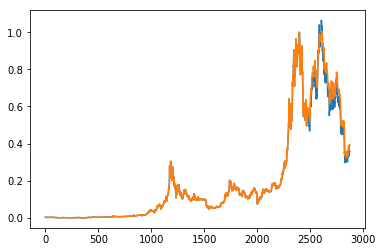

In [100]:
price=np.concatenate([y_train_scaled.ravel(), y_test_scaled.ravel()])
prediction=np.concatenate([y_train_scaled.ravel(), y_predicted.ravel()])
fig=plt.figure()
plt.plot(price)
plt.plot(prediction)

In [109]:
next_prediction_input=df.iloc[-5:]['Close'].values
next_prediction_input_scaled=X_scaler.transform([next_prediction_input])

In [111]:
next_prediction_input_scaled

array([[0.37075362, 0.36571124, 0.36535281, 0.36004559, 0.35796728]])

In [112]:
next_prediction=model.predict([next_prediction_input_scaled])
next_prediction

1/1 [==============================] - 2s 2s/step


array([[0.39324838]], dtype=float32)

In [113]:
y_scaler.inverse_transform(next_prediction)

array([[25080.695]], dtype=float32)